## IMPORTY

In [127]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, precision_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
import pandas as pd
from pathlib import Path

### Załadowanie danych


In [128]:
FILE = Path(f"{os.getcwd()}\\main_data.json")
if not os.path.isfile(FILE):
    raise FileNotFoundError("Nie odnaleziono pliku!")
else:
    print(f"Plik {FILE} już jest na dysku")

data = pd.read_json(FILE)
data.info()

Plik d:\AI_the_beginning\raport\main_data.json już jest na dysku
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7850 entries, 0 to 7849
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   map           7850 non-null   object
 1   team_A        7850 non-null   object
 2   team_A_score  7850 non-null   int64 
 3   team_B        7850 non-null   object
 4   team_B_score  7850 non-null   int64 
 5   id            7850 non-null   int64 
 6   A_rank        7850 non-null   int64 
 7   B_rank        7850 non-null   int64 
 8   A_stats       7850 non-null   object
 9   B_stats       7848 non-null   object
dtypes: int64(5), object(5)
memory usage: 613.4+ KB


Dane są prawie pełne, w dwóch meczach brakuje statystyk odnośnie drużyny B. Pozwolę sobie je usunąć, gdyż 2 w mecze w kontekście prawie 8000 nie wpłyną na wyniki analizy

In [129]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7848 entries, 0 to 7849
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   map           7848 non-null   object
 1   team_A        7848 non-null   object
 2   team_A_score  7848 non-null   int64 
 3   team_B        7848 non-null   object
 4   team_B_score  7848 non-null   int64 
 5   id            7848 non-null   int64 
 6   A_rank        7848 non-null   int64 
 7   B_rank        7848 non-null   int64 
 8   A_stats       7848 non-null   object
 9   B_stats       7848 non-null   object
dtypes: int64(5), object(5)
memory usage: 674.4+ KB


## Preprocessing

Transformacja danych (rozwinięcie słownika na kolumny)

In [130]:
def expand_dictionary_in_dataframe(frame: pd.DataFrame, column_name: str):
    frame[column_name].apply(pd.Series)
    expanded_cols = frame[column_name].apply(pd.Series)
    new_names = {col: f"{column_name[0]}_{col}" for col in expanded_cols.columns}
    expanded_cols = expanded_cols.rename(columns=new_names)
    frame = frame.drop(column_name, axis=1)
    return frame.join(expanded_cols)


# wydarzył się jeden mecz na mapie Train, nie będziemy brać tego meczu pod uwagę
trains_matches = data[(data['map'] == "Train")].index
data = data.drop(trains_matches)

print(set(data['map']))
data = expand_dictionary_in_dataframe(data, "A_stats")
data = expand_dictionary_in_dataframe(data, "B_stats")
data

{'Ancient', 'Nuke', 'Overpass', 'Dust2', 'Anubis', 'Vertigo', 'Inferno', 'Mirage'}


,map,team_A,team_A_score,team_B,team_B_score,id,A_rank,B_rank,A_AVG_K,A_AVG_A,...,A_AVG_Rating2.0,A_AVG_HS,B_AVG_K,B_AVG_A,B_AVG_D,B_AVG_KAST,B_AVG_ADR,B_AVG_FK Diff,B_AVG_Rating2.0,B_AVG_HS
0,Mirage,Spirit,4,MOUZ,13,175885,6,2,9.2,2.6,...,0.716,4.2,14.8,4.2,9.2,82.36,87.10,1.0,1.474,7.0
1,Ancient,Spirit,9,MOUZ,13,175881,6,2,14.2,4.4,...,0.946,8.2,16.0,6.6,14.2,78.18,79.64,1.6,1.208,9.2
2,Vertigo,Spirit,11,MOUZ,13,175876,6,2,14.6,3.8,...,1.006,6.2,15.6,6.6,14.6,74.16,73.98,0.6,1.130,8.8
3,Mirage,MOUZ,13,HEROIC,8,175801,2,13,15.2,3.6,...,1.218,7.8,12.6,4.4,15.2,64.78,69.16,-0.6,0.892,5.6
4,Dust2,MOUZ,13,HEROIC,9,175788,2,13,15.0,5.4,...,1.130,7.2,12.2,4.4,15.2,64.56,64.16,0.0,0.916,6.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7845,Anubis,Falcons,13,FORZE,16,164679,56,58,19.6,5.8,...,1.040,8.6,20.2,7.2,19.6,71.72,73.62,-1.4,1.096,11.6
7846,Vertigo,Anonymo,4,ECSTATIC,13,164678,62,70,9.0,3.4,...,0.748,4.2,15.0,7.8,9.2,84.72,88.88,0.6,1.468,6.2
7847,Ancient,Anonymo,6,ECSTATIC,13,164677,62,70,9.6,2.4,...,0.816,5.6,12.2,4.8,9.8,77.88,68.10,1.2,1.208,6.8
7848,Ancient,00NATION,13,Permitta,5,164676,44,68,15.8,6.0,...,1.470,8.0,9.0,3.2,16.2,54.44,61.72,-1.6,0.698,5.8


Usunięcie kolumn z nazwami drużyn i ID meczu - nie są potrzebne do analizy

In [131]:
data = data.drop("team_A", axis=1)
data = data.drop("team_B", axis=1)
data = data.drop("id", axis=1)

Nowe nazwy dla rund zdobtych przez drużyny

In [132]:
data = data.rename(columns={'team_A_score' : 'A_score', 'team_B_score' : 'B_score'})

Dodanie kolumn o tym kto wygrał mecz. Dodam kolumnę 'Winner' gdzie będą mogły się znajdować 2 wartości: A, B. Nie ma możliwości zakończenia się meczu remisem. Pózniej wykorzystam Ordinal encoder do zamiany wartości na wartość numeryczną<br>
|Condition|Winner|
|---|---|
|A_score $\gt$ B_score| A|
|A_score $\lt$ B_score| B|

Oraz dodanie tieru drużyny na podstawie rankingu:
|Condition|Tier|
|---|---|
|rank $\leq$ 20|1|
|20 $\lt$ rank $\leq$ 80|2|
|80 $\lt$ rank|3|

In [133]:

data["A tier"] = data["A_rank"].apply(lambda x: 1 if x <= 20 else (2 if x <= 80 else 3))
data["B tier"] = data["B_rank"].apply(lambda x: 1 if x <= 20 else (2 if x <= 80 else 3))
data["Winner"] = np.where(data["A_score"] > data["B_score"], "A", "B")
data

,map,A_score,B_score,A_rank,B_rank,A_AVG_K,A_AVG_A,A_AVG_D,A_AVG_KAST,A_AVG_ADR,...,B_AVG_A,B_AVG_D,B_AVG_KAST,B_AVG_ADR,B_AVG_FK Diff,B_AVG_Rating2.0,B_AVG_HS,A tier,B tier,Winner
0,Mirage,4,13,6,2,9.2,2.6,14.8,48.20,64.50,...,4.2,9.2,82.36,87.10,1.0,1.474,7.0,1,1,B
1,Ancient,9,13,6,2,14.2,4.4,16.0,67.26,69.74,...,6.6,14.2,78.18,79.64,1.6,1.208,9.2,1,1,B
2,Vertigo,11,13,6,2,14.6,3.8,15.8,66.64,69.20,...,6.6,14.6,74.16,73.98,0.6,1.130,8.8,1,1,B
3,Mirage,13,8,2,13,15.2,3.6,12.6,76.20,79.30,...,4.4,15.2,64.78,69.16,-0.6,0.892,5.6,1,1,A
4,Dust2,13,9,2,13,15.0,5.4,12.2,68.18,73.40,...,4.4,15.2,64.56,64.16,0.0,0.916,6.6,1,1,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7845,Anubis,13,16,56,58,19.6,5.8,20.2,68.98,72.24,...,7.2,19.6,71.72,73.62,-1.4,1.096,11.6,2,2,B
7846,Vertigo,4,13,62,70,9.0,3.4,15.0,56.44,61.30,...,7.8,9.2,84.72,88.88,0.6,1.468,6.2,2,2,B
7847,Ancient,6,13,62,70,9.6,2.4,12.4,62.10,55.60,...,4.8,9.8,77.88,68.10,1.2,1.208,6.8,2,2,B
7848,Ancient,13,5,44,68,15.8,6.0,9.0,86.66,91.48,...,3.2,16.2,54.44,61.72,-1.6,0.698,5.8,2,2,A


## Wstępna analiza

## Mapy

Rozkład liczby meczów na pozsczególnych mapach


[]

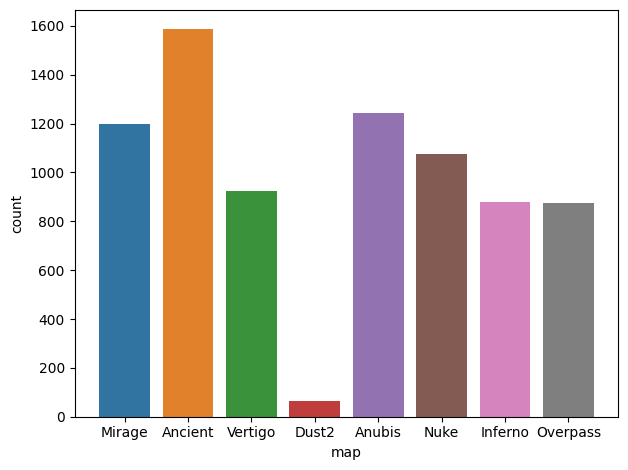

In [134]:
sns.countplot(data, hue='map', x='map')
plt.tight_layout()
plt.plot()

Mapa Dust2 odstaje, gdyż w ostatnim czasie zmienił się map pool, za Overpassa wszedł właśnie Dust2 i nie rozegrano na nim jeszcze wiele meczów.

## Zakres statystyk drużyn

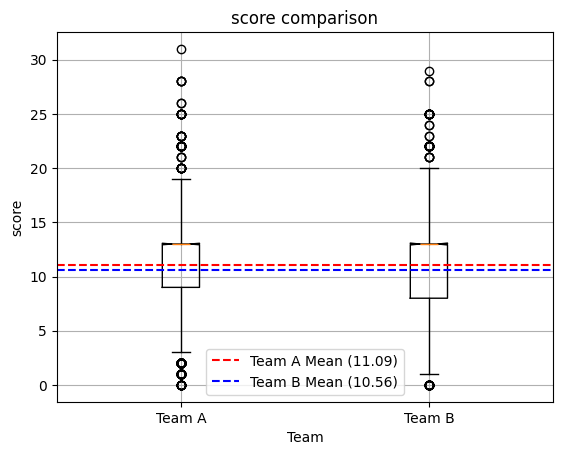

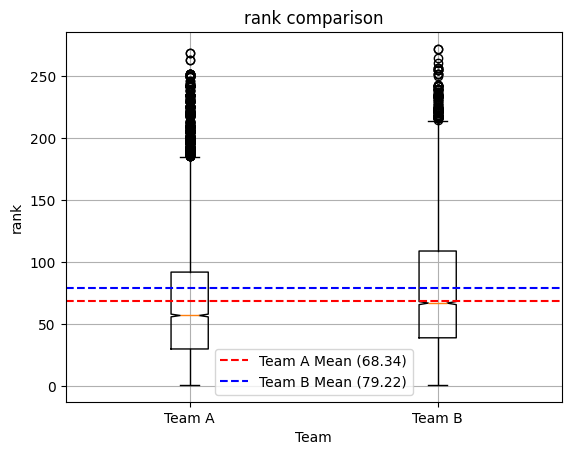

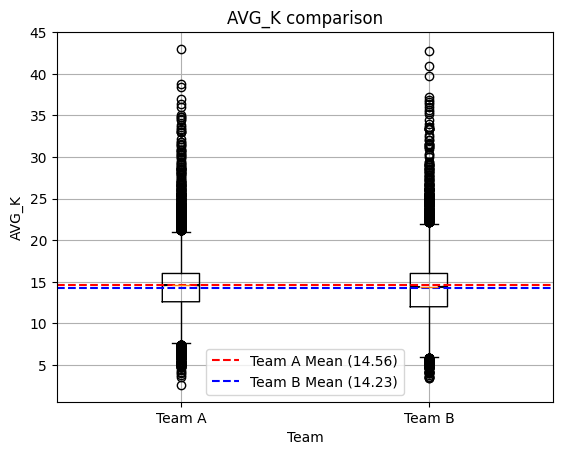

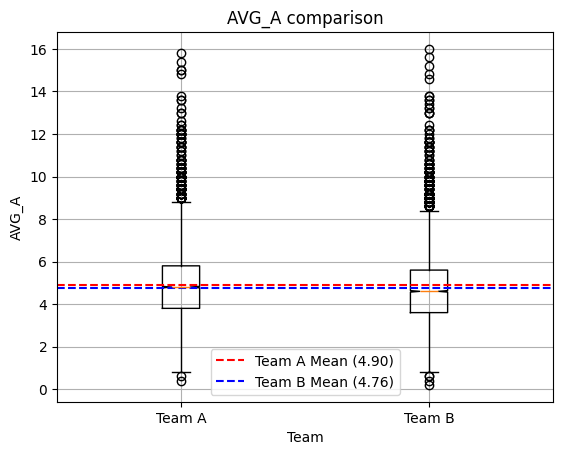

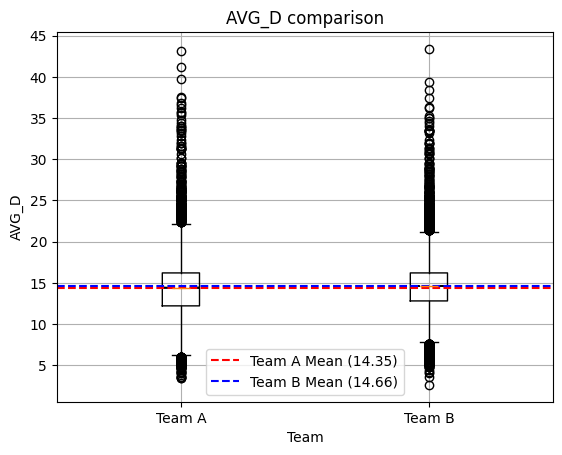

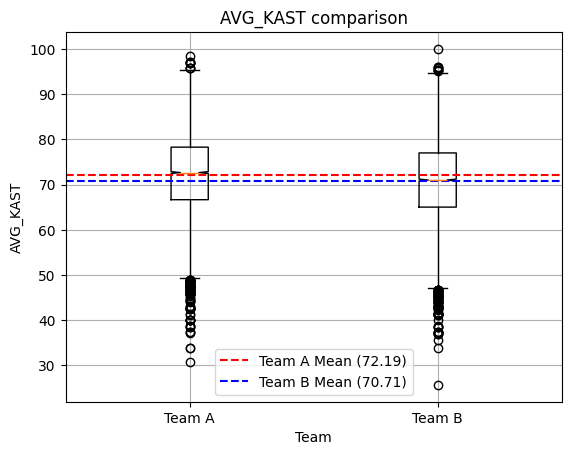

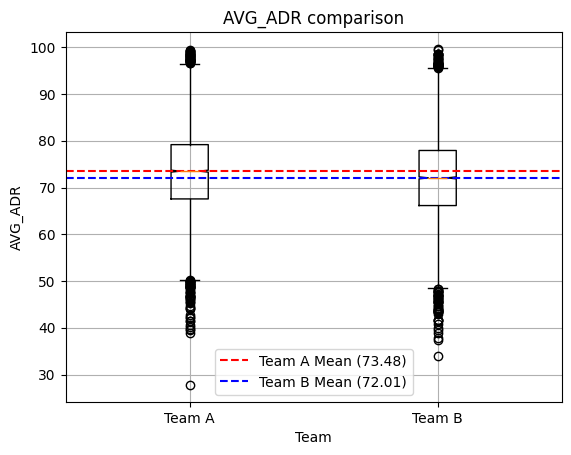

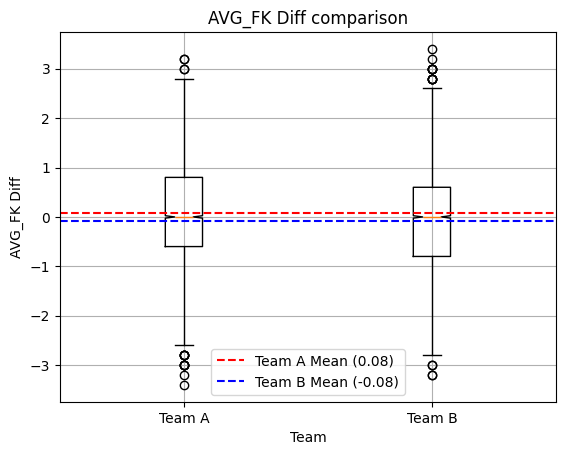

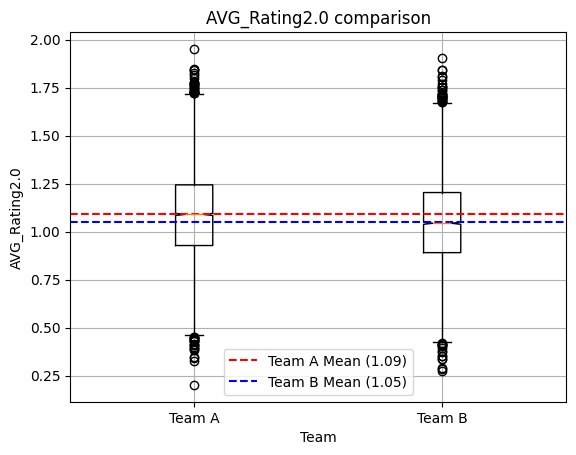

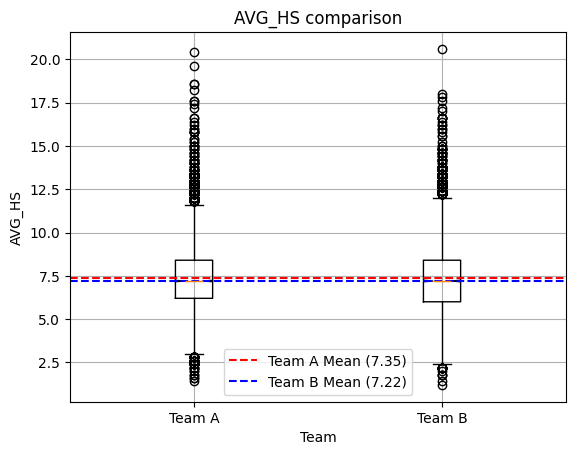

In [135]:
# Extract Team A and Team B data (assuming separate columns)
team_a_data = data[[col for col in data.columns if col.startswith('A_')]]
team_b_data = data[[col for col in data.columns if col.startswith('B_')]]

for feature_A, feature_B in zip(team_a_data.columns, team_b_data.columns):
    # Extract data and labels
    team_a_values = team_a_data[feature_A]
    team_b_values = team_b_data[feature_B]
    feature_name = feature_A[2:]  # Remove 'A_' prefix

    # Create a box plot
    plt.figure()
    plt.boxplot([team_a_values, team_b_values], labels=['Team A', 'Team B'], notch=True)
    plt.title(f"{feature_name} comparison")

    plt.axhline(y=np.mean(team_a_data[feature_A]), color='red', linestyle='dashed', label=f'Team A Mean ({np.mean(team_a_data[feature_A]):.2f})')
    plt.axhline(y=np.mean(team_b_data[feature_B]), color='blue', linestyle='dashed', label=f'Team B Mean ({np.mean(team_b_data[feature_B]):.2f})')

    plt.xlabel('Team')
    plt.ylabel(feature_name)
    plt.legend()
    plt.grid(True)
    plt.show()

Dla wartości, które bezpośrednio zależą od liczby rozegranych rund, takich jak kille, asysty, headshoty, śmierci, wygrane rundy, jest znacznie więcej lierów niż dla wartości, które są niezależne od liczby rund, tj. KAST, Rating, FK_Diff, ADR. <br>
Jednak tych wartości odstających nie musimy usuwać, gdyż są one związane z liczbą rozegranych rund i są zależne liniowo od tej liczby.

### Porównanie zależności między wygranym meczem, a tierami drużyn

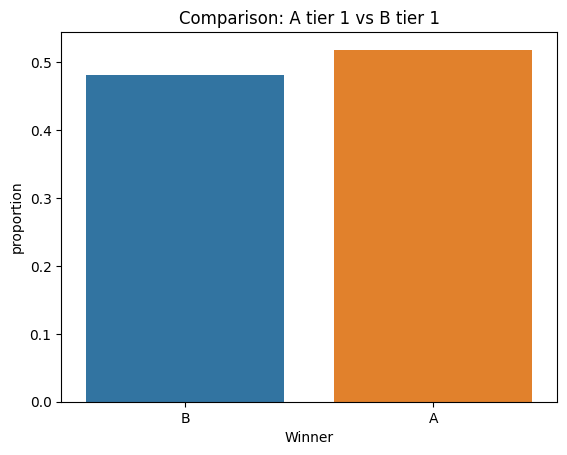

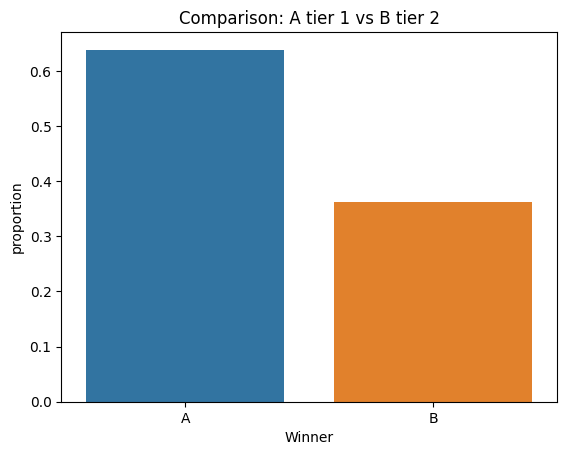

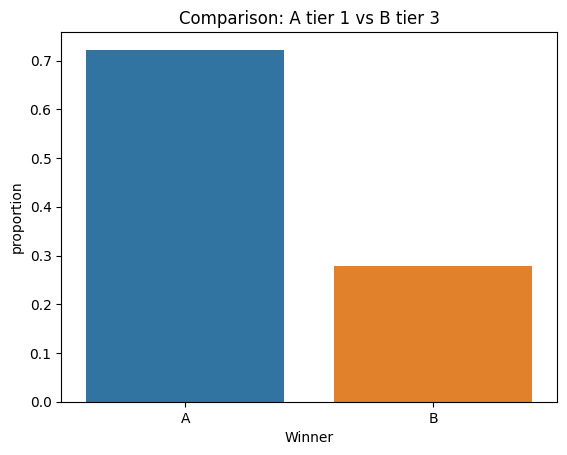

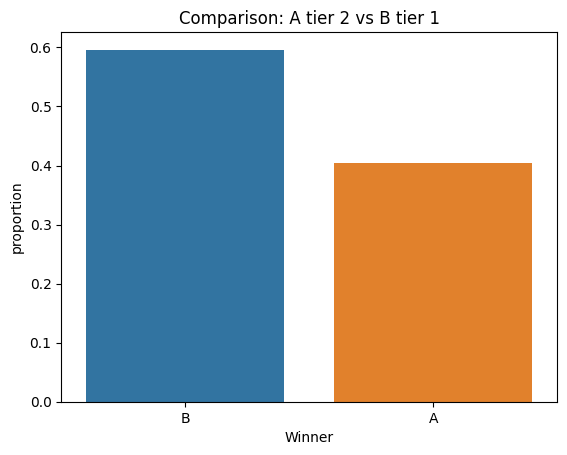

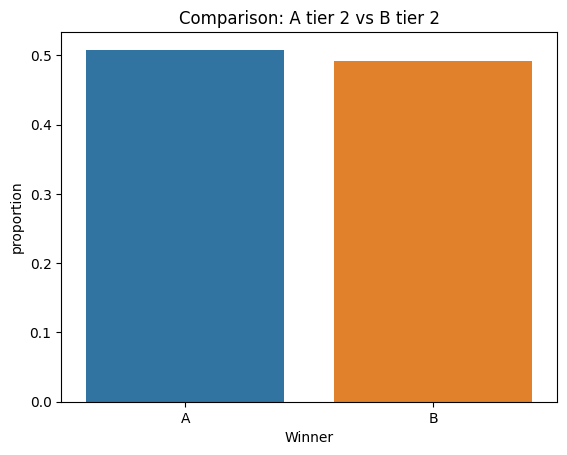

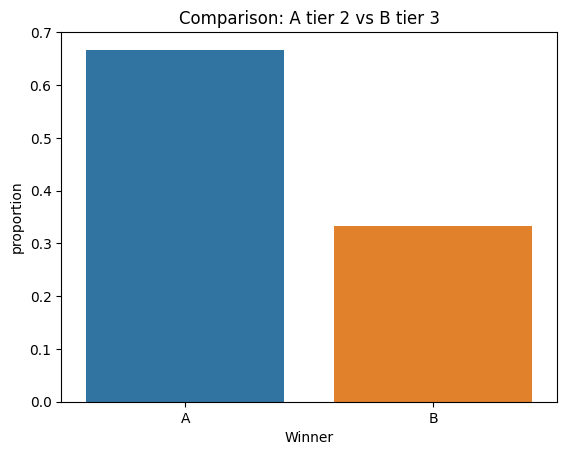

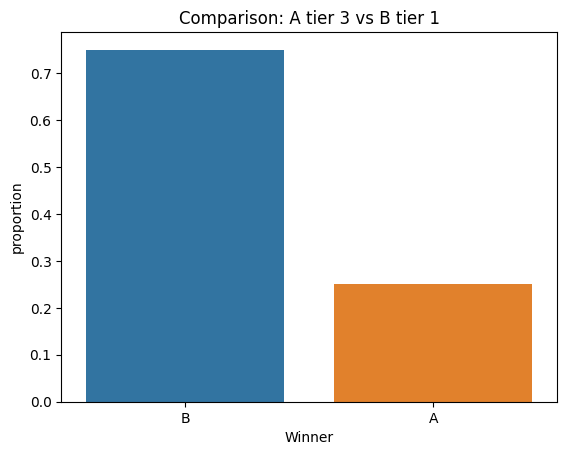

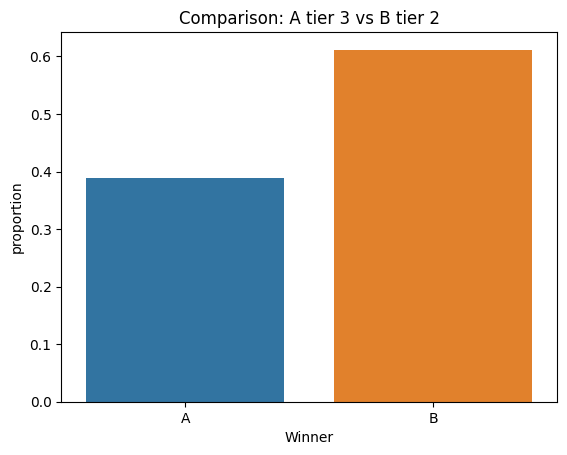

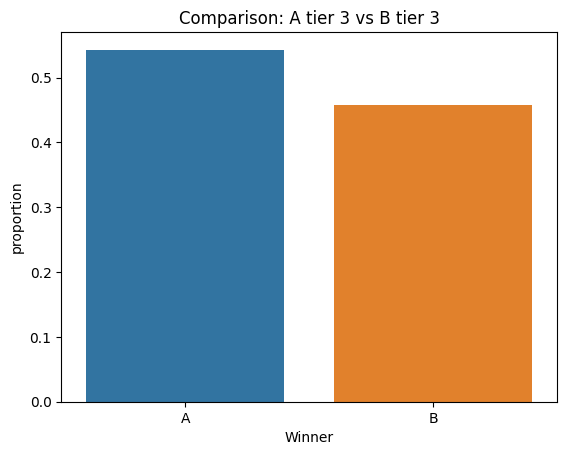

In [136]:
def filter_matches_by_team_tier(tier1: int, tier2: int):
    """
    Returns matches where teams are from a given tiers.
    """
    matchups = (data["A tier"] == tier1) & (data["B tier"] == tier2)
    return data[matchups]


for tiers in np.array(np.meshgrid([1, 2, 3], [1, 2, 3])).T.reshape(-1, 2):
    sns.countplot(
        x="Winner",
        data=filter_matches_by_team_tier(*tiers),
        hue="Winner",
        stat="proportion",
    )
    plt.title(f"Comparison: A tier {tiers[0]} vs B tier {tiers[1]}")
    plt.show()

Można zauważyć, że jeśli spotykają się drużyny z tego samego tieru to szansa na wygranie jednej z drużyn wynosi około 50%. Szansa ta rośnie jeśli różnica między tierami rośnie (drużyna z lepszego tieru ma większe szanse).

### Pórwnanie wpływu mapy na wynik meczu, w zależności od tieru drużyny

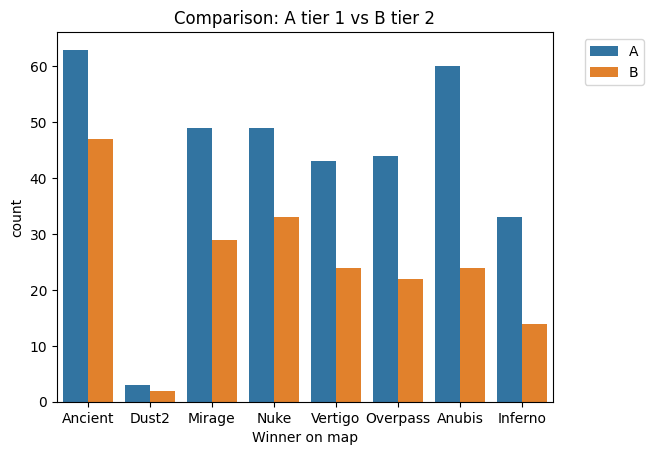

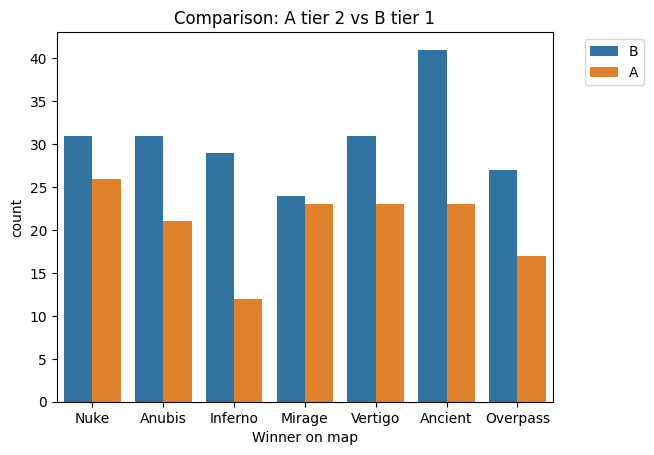

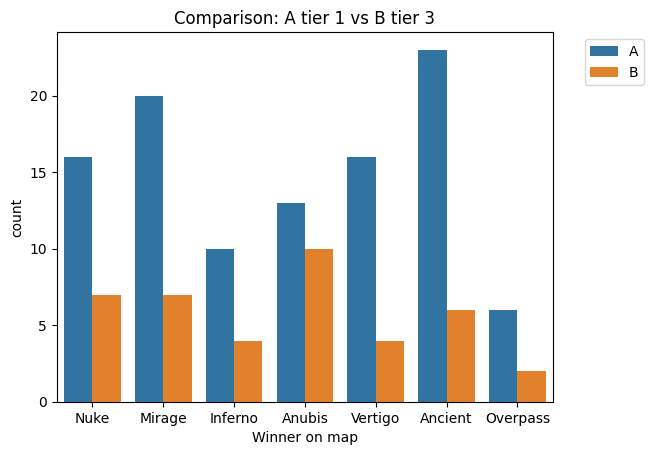

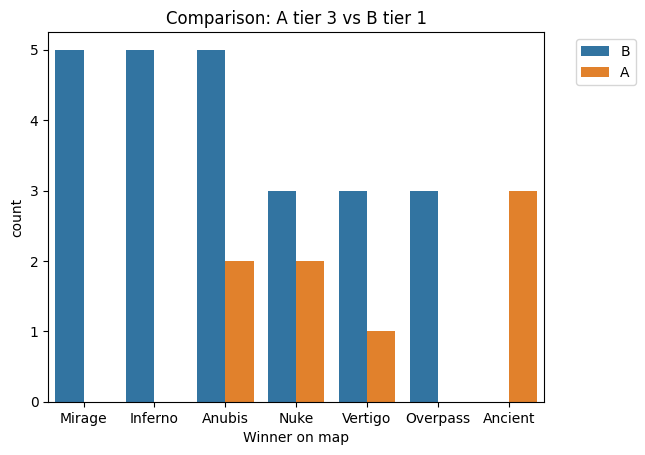

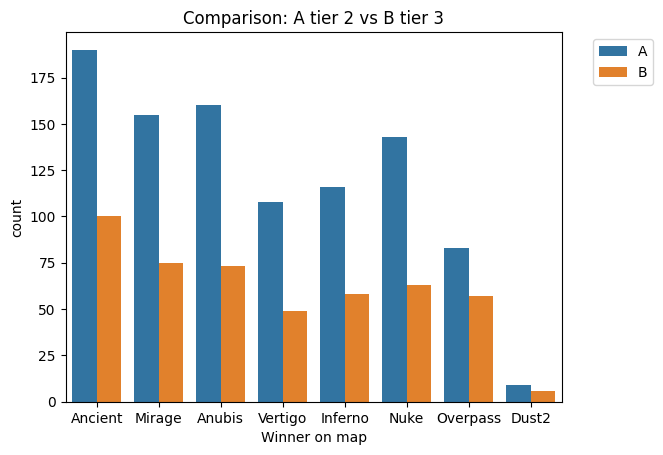

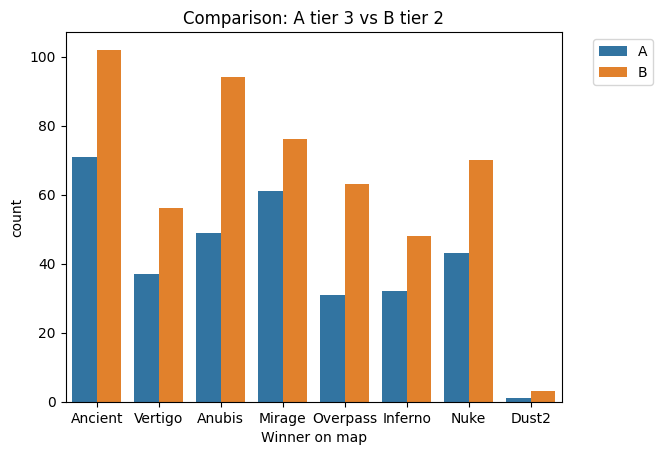

In [137]:
for tiers in [(1, 2), (2, 1), (1, 3), (3, 1), (2, 3), (3, 2)]:
    sns.countplot(
        x="map",
        data=filter_matches_by_team_tier(*tiers),
        hue="Winner",
    ).set_xlabel("Winner on map")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.title(f"Comparison: A tier {tiers[0]} vs B tier {tiers[1]}")
    plt.show()

Z powyższych wykresów można wywnioskować, że jesli grają drużyny z 1 i 2 tieru, to na Anubisie i Inferno drużyna z 1 tieru ma większe szanse.<br>
Sytuacja się zmienia jeśli 1 tier gra z tierem 3, wtedy Ancient jest najlepszym wyborem dla drużyny z tieru 1.<br>
Jesli chodzi o tier 2 i 3, to Ancient, Anubis oraz Nuke, zwiększałyby szanse na wygraną dla drużyny z tieru 2.

### Enkodowanie cech kategorycznych

Enkodowanie wartości map przy użyciu OrdinalEncodera

In [138]:
encoder = OrdinalEncoder(dtype=int)
encoder.fit(data[["map", "Winner"]])
data[["map", "Winner"]] = encoder.transform(data[["map", "Winner"]])


## Przygotowanie danych do trenowania modelu

Rodzielenie cech od wartości do predykowania

In [139]:
def split_dataset(dataset, features: list[str]):
    results_cols = ["Winner"]
    return dataset[features], dataset[results_cols]

Skalowanie danych


In [140]:
def scale_features(dataset, scaler):
        return scaler.fit_transform(dataset.astype(float))

## Downsampling
Z racji iż występuje nierównowaga co do liczności klas postanowiłem je wyrównać, na "surowych danych" model znacząco częściej predykował dominującą klasę.<br>
Po downsamplingu zaczął bardziej równomiernie przewidywać wyniki.

In [141]:
winner_distribution = data['Winner'].value_counts()
print(winner_distribution)

from sklearn.utils import resample

# Separate majority and minority classes
df_majority = data[data['Winner'] == 0]
df_minority = data[data['Winner'] == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),     # to match minority class
                                   random_state=123) # reproducible results

# Combine minority class with downsampled majority class
data_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
print(data_downsampled['Winner'].value_counts())
data_downsampled

Winner
0    4235
1    3612
Name: count, dtype: int64
Winner
0    3612
1    3612
Name: count, dtype: int64


,map,A_score,B_score,A_rank,B_rank,A_AVG_K,A_AVG_A,A_AVG_D,A_AVG_KAST,A_AVG_ADR,...,B_AVG_A,B_AVG_D,B_AVG_KAST,B_AVG_ADR,B_AVG_FK Diff,B_AVG_Rating2.0,B_AVG_HS,A tier,B tier,Winner
7604,1,16,12,77,68,17.8,6.0,19.6,67.84,68.58,...,5.8,17.8,74.28,74.26,2.0,1.144,10.6,2,2,0
6326,0,13,11,125,108,16.4,4.8,16.8,74.98,77.44,...,5.6,17.4,64.18,72.70,-0.4,0.984,4.6,3,3,0
455,1,13,2,11,38,11.4,3.4,7.4,85.32,77.68,...,2.0,11.4,58.66,60.58,-1.8,0.682,4.0,1,2,0
1932,0,13,4,180,124,14.8,6.0,8.6,85.86,90.28,...,3.8,14.8,56.46,57.52,-1.0,0.658,3.6,3,3,0
3417,7,13,5,27,87,14.4,5.6,10.8,81.10,86.62,...,3.6,14.4,71.12,66.34,-0.4,0.900,6.4,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7840,1,8,13,37,57,14.0,3.8,16.0,68.56,73.58,...,4.4,14.0,77.16,80.32,1.0,1.212,9.4,2,2,1
7843,4,6,13,56,58,9.6,3.2,14.6,50.54,58.44,...,5.8,9.6,83.16,81.32,0.6,1.384,8.8,2,2,1
7845,1,13,16,56,58,19.6,5.8,20.2,68.98,72.24,...,7.2,19.6,71.72,73.62,-1.4,1.096,11.6,2,2,1
7846,7,4,13,62,70,9.0,3.4,15.0,56.44,61.30,...,7.8,9.2,84.72,88.88,0.6,1.468,6.2,2,2,1


Wybór najlepszych parametrów do modelu za pomocą GridSearchCV

In [142]:
def find_best_parameters(model, parameters, X, y, cv=10, n_jobs=-1):
    grid_object = GridSearchCV(
        model,
        parameters,
        scoring=make_scorer(precision_score),
        cv=cv,
        n_jobs=n_jobs,
    )
    grid_object = grid_object.fit(X, y)
    return grid_object.best_estimator_

Tworzenie modeli na różnych cechach

In [143]:
FEATURES = [
    data.columns.delete([1, 2, len(data.columns) - 1]),
    ["A_score", "B_score"],
    ["A_rank", "B_rank"],
    ["A_rank", "B_rank", "A tier", "B tier"],
    ["A_AVG_K", "A_AVG_D", "B_AVG_K", "B_AVG_D"],
    ["A_AVG_ADR", "B_AVG_ADR"],
    ["A_AVG_KAST", "B_AVG_KAST"],
    ["A_AVG_FK Diff", "B_AVG_FK Diff"],
    ["A_AVG_Rating2.0", "B_AVG_Rating2.0"],
    ["map", "A tier", "B tier"],
]

results = []

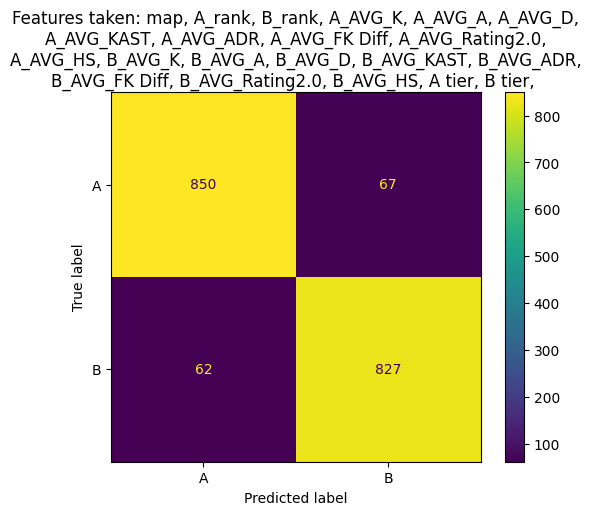

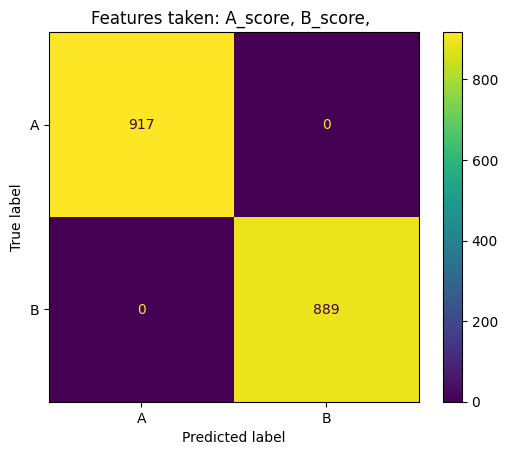

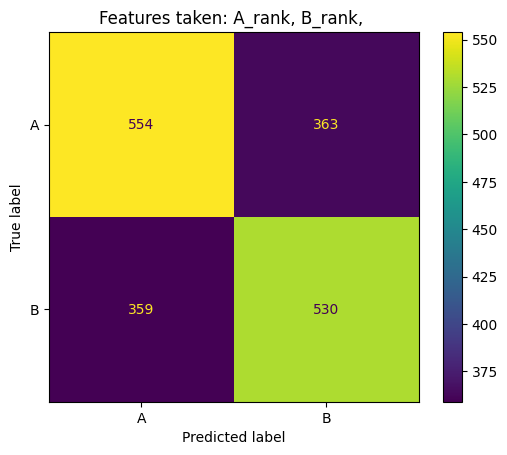

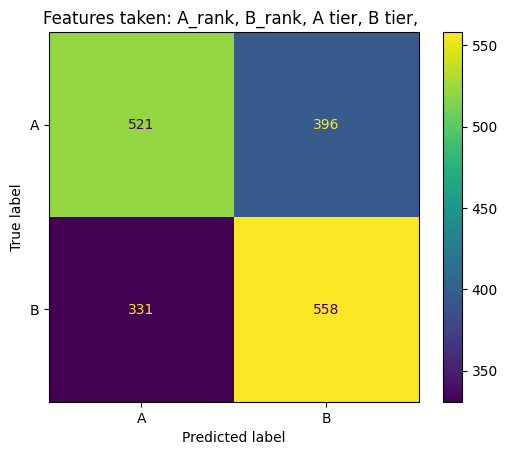

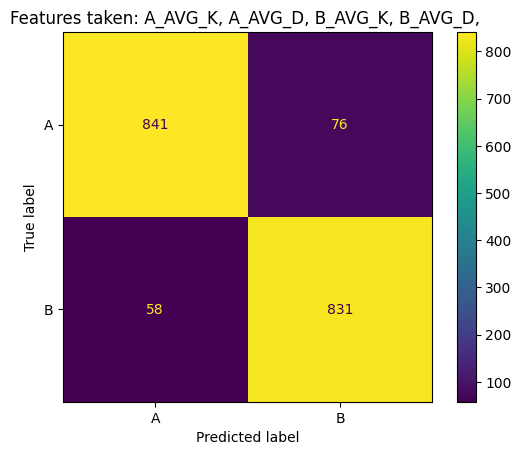

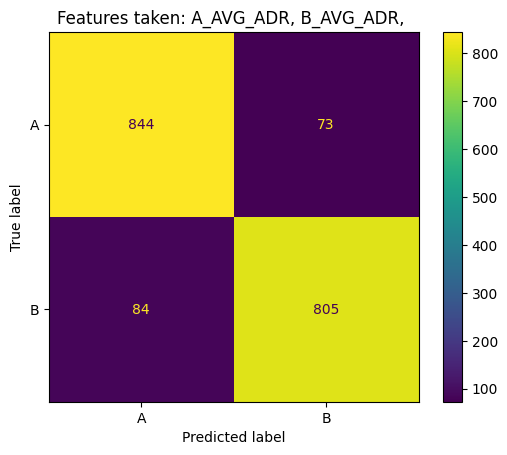

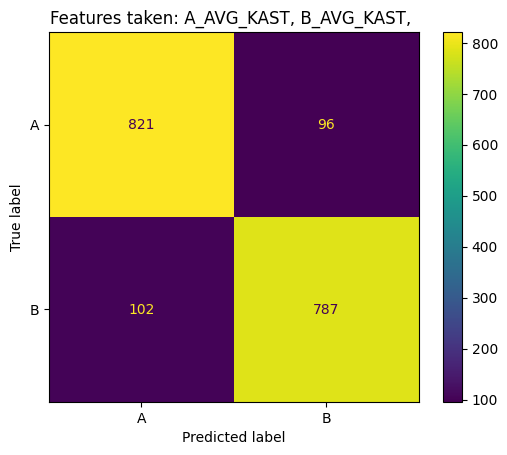

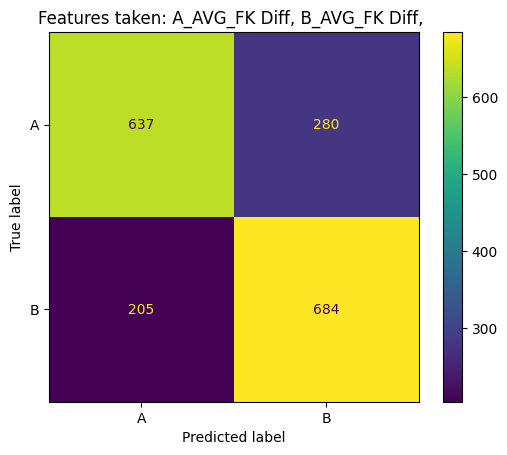

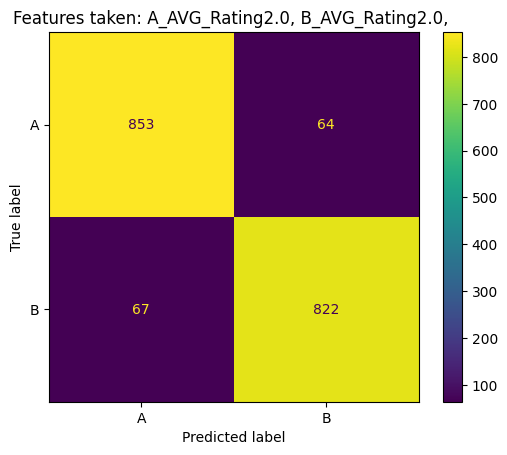

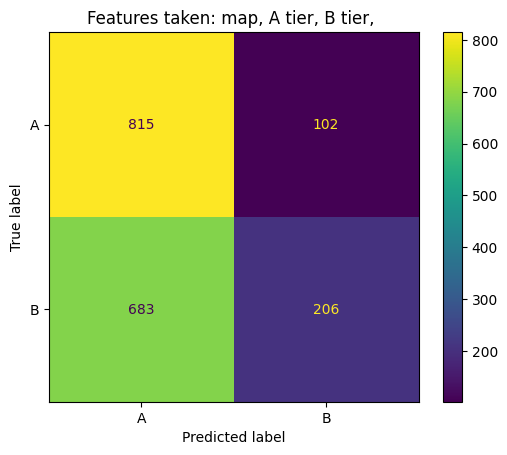

,Features,Precision
0,"map, A_rank, B_rank, A_AVG_K, A_AVG_A, A_AVG_D...",0.925256
1,"A_score, B_score,",1.000000
2,"A_rank, B_rank,",0.599974
3,"A_rank, B_rank, A tier, B tier,",0.592492
4,"A_AVG_K, A_AVG_D, B_AVG_K, B_AVG_D,",0.928686
5,"A_AVG_ADR, B_AVG_ADR,",0.918427
6,"A_AVG_KAST, B_AVG_KAST,",0.885356
7,"A_AVG_FK Diff, B_AVG_FK Diff,",0.710682
8,"A_AVG_Rating2.0, B_AVG_Rating2.0,",0.928894
9,"map, A tier, B tier,",0.572067


In [144]:
for set_of_features in FEATURES:
    X, Y = split_dataset(data_downsampled, set_of_features)
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, train_size=0.75, random_state=42, shuffle=True
    )
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    scaler = StandardScaler()
    X_train = scale_features(X_train, scaler)
    X_test = scale_features(X_test, scaler)

    clf = SVC()

    parameters = {"C": [1.0, 2.0, 4.0], "gamma": [0.001, 0.1, 1.0, 10.0]}

    clf = find_best_parameters(clf, parameters, X_train, y_train)

    y_pred = clf.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=[clf.classes_])
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["A", "B"],
    )
    disp.plot()

    str_features = "".join(f"{x}, " for x in set_of_features)
    plt.title(f"Features taken: {str_features}", wrap=True)

    plt.show()

    results.append(
        [
            str_features,
            np.mean(cross_val_score(clf, X_train, y_train, scoring="precision", cv=10)),
        ]
    )

pd.DataFrame(results, columns=["Features", "Precision"])